## Mortality prediction (sepsis only, gene expression)

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

In [30]:
# Load gene expression (samples × genes)
X = pd.read_csv("../../data/res_array/expr_sh_samplesxgenes.csv", index_col=0)

# Load phenotype data
pheno = pd.read_csv("../../data/res_array/pheno_sub_GSE65682.csv")

##### Prepare dataframes

In [31]:
# ------------------------------------------------------------
# 1) Put phenotype rows on the same identifier used by X
#    - Drops a useless column if present
#    - Sets the sample ID column as the index so it can align with X.index
# ------------------------------------------------------------
pheno = pheno.drop(columns=["Unnamed: 0"], errors="ignore")
pheno = pheno.set_index("geo_accession")

# ------------------------------------------------------------
# 2) Normalize indices to avoid silent mismatches
#    - Ensures both indices are strings
#    - Strips whitespace so 'GSM...' and ' GSM...' do not differ
# ------------------------------------------------------------
X.index = X.index.astype(str).str.strip()
pheno.index = pheno.index.astype(str).str.strip()

# ------------------------------------------------------------
# 3) Align X and pheno to the same sample set and order
#    - Takes the intersection of sample IDs
#    - Subsets both objects to those samples in the same order
# ------------------------------------------------------------
common = X.index.intersection(pheno.index)
X = X.loc[common].copy()
pheno = pheno.loc[common].copy()

# ------------------------------------------------------------
# 4) Subset to sepsis samples and match X rows to them
# ------------------------------------------------------------
pheno_sepsis = pheno.loc[pheno["sepsis_status"].eq("Sepsis")].copy()
X_sepsis = X.loc[pheno_sepsis.index].copy()

# ------------------------------------------------------------
# 5) Define the mortality prediction target
#    - Keep only sepsis samples with observed 28-day mortality outcome
#    - Realign X to the filtered phenotype index (guarantees same rows)
#    - Build y as integer labels
# ------------------------------------------------------------
pheno_sepsis = pheno_sepsis.loc[pheno_sepsis["mortality_event_28days"].notna()].copy()
X_sepsis = X_sepsis.loc[pheno_sepsis.index].copy()
y = pheno_sepsis["mortality_event_28days"].astype(int)

# Optional sanity check (single, non-redundant)
print("Shapes:", X_sepsis.shape, pheno_sepsis.shape, "y:", y.shape)
print("Indices aligned:", X_sepsis.index.equals(pheno_sepsis.index))

Shapes: (479, 19434) (479, 17) y: (479,)
Indices aligned: True


In [32]:
print(X_sepsis.head())

                A1BG      A1CF       A2M     A2ML1   A3GALT2    A4GALT  \
GSM1602802  2.271442  1.976984  2.160783  1.877168  2.103778  2.169609   
GSM1602803  2.392636  1.879486  1.974665  1.778825  2.105756  2.124426   
GSM1602805  2.395100  2.013629  2.330720  1.812598  2.112445  2.132527   
GSM1602810  2.950641  1.987343  2.128909  1.852028  1.871829  2.270631   
GSM1602811  2.249851  2.136212  1.743872  2.050351  2.134418  2.215221   

               A4GNT      AAAS      AACS    AACSP1  ...    ZWILCH     ZWINT  \
GSM1602802  2.101550  2.445301  2.472728  2.104310  ...  2.664040  2.946011   
GSM1602803  2.166700  2.697144  2.413497  2.272301  ...  2.686085  2.548945   
GSM1602805  2.195936  2.692986  2.362931  2.507019  ...  2.541701  2.770111   
GSM1602810  2.224265  2.275688  2.318958  2.245257  ...  2.596857  2.269327   
GSM1602811  2.356048  2.313982  2.432858  2.054722  ...  2.420972  2.275693   

                ZXDA      ZXDB      ZXDC    ZYG11A    ZYG11B       ZYX  \
GSM160

In [34]:
print(pheno_sepsis.columns)

Index(['title', 'abdominal_sepsis_and_controls', 'age', 'diabetes_mellitus',
       'endotype_class', 'endotype_cohort', 'gender',
       'icu_acquired_infection_paired', 'icu_acquired_infection',
       'mortality_event_28days', 'pneumonia diagnoses', 'thrombocytopenia',
       'time_to_event_28days', 'subject', 'ID', 'sepsis_status', 'severity'],
      dtype='object')


#### Keep only mortality label  

In [35]:
mask = pheno_sepsis["mortality_event_28days"].notna()

X_mort = X_sepsis.loc[mask].copy()
y_mort = pheno_sepsis.loc[mask, "mortality_event_28days"].astype(int)

print(X_mort.shape, y_mort.shape)
print(y_mort.value_counts())

(479, 19434) (479,)
mortality_event_28days
0    365
1    114
Name: count, dtype: int64


## TRAIN - TEST Split
_____________

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
     X_mort, y_mort, test_size=0.2, stratify=y_mort, random_state=42
)

## Top-K gene selector (training-only) + pipeline component
_________________

In [37]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class TopKVarianceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=5000):
        self.k = k
        self.keep_idx_ = None
        self.keep_cols_ = None

    def fit(self, X, y=None):
        # Variance computed on TRAIN only
        var = np.var(X, axis=0)
        k = min(self.k, X.shape[1])
        self.keep_idx_ = np.argsort(var)[::-1][:k]
        # keep column names if pandas
        if hasattr(X, "columns"):
            self.keep_cols_ = X.columns[self.keep_idx_]
        return self

    def transform(self, X):
        if hasattr(X, "iloc"):
            return X.iloc[:, self.keep_idx_]
        return X[:, self.keep_idx_]

## Define 4 models (baseline + 3 complex) with tuning

______________

##### Logistic ridge (baseline)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

ridge = Pipeline([
    ("topk", TopKVarianceSelector(k=5000)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        class_weight="balanced",
        max_iter=3000
    ))
])

##### Elastic Net logistic

In [44]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

enet = Pipeline([
    ("topk", TopKVarianceSelector(k=5000)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        class_weight="balanced",
        max_iter=4000,
        tol=1e-3,
        random_state=42
    ))
])

param_enet = {
    "topk__k": [50, 100, 1000, 2000],
    "clf__C": [0.05, 0.1, 0.5, 1.0],
    "clf__l1_ratio": [0.0, 0.5, 1.0]
}

#### Random Forest 

In [51]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ("topk", TopKVarianceSelector(k=5000)),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=1
    ))
])

param_rf = {
    "topk__k": [50, 100, 1000, 2000],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": ["sqrt", "log2", 0.1]
}

#### Gradient Boosting

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

gb = Pipeline([
    ("topk", TopKVarianceSelector(k=5000)),
    ("clf", GradientBoostingClassifier(random_state=42))
])

param_gb = {
    "topk__k": [50, 100, 1000, 2000],
    "clf__n_estimators": [200, 400],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__max_depth": [2, 3]
}

## Cross-validated tuning on training set only
______________________

In [ ]:
# time = 15min

from sklearn.metrics import roc_auc_score
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_enet = GridSearchCV(enet, param_enet, scoring="roc_auc", cv=cv, n_jobs=4)
grid_rf   = GridSearchCV(rf,   param_rf,   scoring="roc_auc", cv=cv, n_jobs=4)
grid_gb   = GridSearchCV(gb,   param_gb,   scoring="roc_auc", cv=cv, n_jobs=4)

# Baseline ridge has no tuning (but still uses TopK)
ridge.fit(X_train, y_train)

grid_enet.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)

print("Best ENET:", grid_enet.best_score_, grid_enet.best_params_)
print("Best RF:  ", grid_rf.best_score_,   grid_rf.best_params_)
print("Best GB:  ", grid_gb.best_score_,   grid_gb.best_params_)

Best ENET: 0.6896293675939312 {'clf__C': 0.05, 'clf__l1_ratio': 0.0, 'topk__k': 2000}
Best RF:   0.6441036841079905 {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10, 'topk__k': 2000}
Best GB:   0.650449277294151 {'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__n_estimators': 400, 'topk__k': 2000}


## Final evaluation on held-out test set (AUROC)
________________

In [54]:
proba_ridge = ridge.predict_proba(X_test)[:, 1]
proba_enet  = grid_enet.best_estimator_.predict_proba(X_test)[:, 1]
proba_rf    = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]
proba_gb    = grid_gb.best_estimator_.predict_proba(X_test)[:, 1]

auc_ridge = roc_auc_score(y_test, proba_ridge)
auc_enet  = roc_auc_score(y_test, proba_enet)
auc_rf    = roc_auc_score(y_test, proba_rf)
auc_gb    = roc_auc_score(y_test, proba_gb)

results = pd.DataFrame({
    "Model": ["Ridge (baseline)", "Elastic Net", "Random Forest", "Grad Boosting"],
    "Test_AUROC": [auc_ridge, auc_enet, auc_rf, auc_gb]
}).sort_values("Test_AUROC", ascending=False)

results

,Model,Test_AUROC
1,Elastic Net,0.713520
2,Random Forest,0.673615
0,Ridge (baseline),0.670637
3,Grad Boosting,0.633711


## ROC comparison plot
_________________

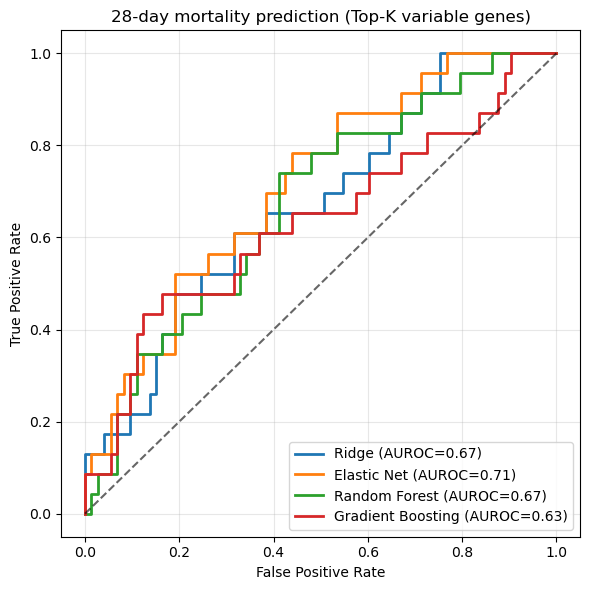

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(6,6))

for name, proba in [
    ("Ridge", proba_ridge),
    ("Elastic Net", proba_enet),
    ("Random Forest", proba_rf),
    ("Gradient Boosting", proba_gb),
]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUROC={auc:.2f})")

plt.plot([0,1],[0,1],"k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("28-day mortality prediction (Top-K variable genes)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Inspect genes used in best linear model

In [58]:
best = grid_enet.best_estimator_
topk = best.named_steps["topk"]
genes_used = X_train.columns[topk.keep_idx_]
print("Number of genes used:", len(genes_used))


Number of genes used: 2000


In [59]:
print(genes_used[:140])

Index(['RPS4Y1', 'MMP8', 'OLFM4', 'IFI27', 'IFIT1', 'IGHV4-31', 'DEFA4',
       'EPSTI1', 'EIF1AY', 'IFIT3',
       ...
       'TREML1', 'TDRD9', 'TMEM176B', 'CA1', 'C1QB', 'RBP7', 'LY6E', 'GLRX5',
       'HAL', 'YOD1'],
      dtype='object', length=140)
